## Ou-Carter mehod
[J. Chem. Theory Comput. 2018, 14, 5680−5689](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.8b00717?casa_token=j3Gzwpzmt0oAAAAA:9PQdZFfkeoICbYk_aXhoPGve8cMwNNmnqTCpsHbN2YrBD-mldE2plJ_iKSUod-w1gUBoIvtUXSPgAGib)

First, build the input wavefunction using Psi4.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.set_num_threads(4)
psi4.core.clean()

import n2v

In [2]:
Ne = psi4.geometry( 
""" 
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf",
                  'DFT_SPHERICAL_POINTS': 350,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 210,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                  'CUBIC_BASIS_TOLERANCE': 1e-21, 
                  'DFT_BASIS_TOLERANCE': 1e-21, 
                 })  # Spin-Restricted

wfn = psi4.properties("CCSD/cc-pcvqz", return_wfn=True, molecule=Ne, properties=["dipole"])[1]

ine = n2v.Inverter(wfn)

In [3]:
x = np.linspace(-5,10,1501)
y = [0]
z = [0]
grid, shape = ine.generate_grids(x,y,z)

In [4]:
v = ine.invert("OC", vxc_grid=grid, guide_potential_components=["hartree"], 
               opt_max_iter=35, frac_old=0.9, init="SCAN")

Iter: 1, Density Change: 1.95e-04, Eigenvalue Change: 6.16e+00.
Iter: 2, Density Change: 3.42e-06, Eigenvalue Change: 1.07e-01.
Iter: 3, Density Change: 1.52e-07, Eigenvalue Change: 1.58e-03.
Iter: 4, Density Change: 1.53e-07, Eigenvalue Change: 1.55e-03.
Iter: 5, Density Change: 1.55e-07, Eigenvalue Change: 1.52e-03.
Iter: 6, Density Change: 1.57e-07, Eigenvalue Change: 1.50e-03.
Iter: 7, Density Change: 1.59e-07, Eigenvalue Change: 1.48e-03.
Iter: 8, Density Change: 1.61e-07, Eigenvalue Change: 1.46e-03.
Iter: 9, Density Change: 1.62e-07, Eigenvalue Change: 1.45e-03.
Iter: 10, Density Change: 1.63e-07, Eigenvalue Change: 1.43e-03.
Iter: 11, Density Change: 1.63e-07, Eigenvalue Change: 1.42e-03.
Iter: 12, Density Change: 1.63e-07, Eigenvalue Change: 1.41e-03.
Iter: 13, Density Change: 1.63e-07, Eigenvalue Change: 1.40e-03.
Iter: 14, Density Change: 1.62e-07, Eigenvalue Change: 1.38e-03.
Iter: 15, Density Change: 1.62e-07, Eigenvalue Change: 1.38e-03.
Iter: 16, Density Change: 1.61e-07

Take a look at the effective external potential:

In [5]:
grid_info = ine.grid_to_blocks(grid)
grid_info[-1].set_pointers(wfn.Da())

In [6]:
vext = ine.on_grid_esp(grid=grid_info)[0]
vext_eff = ine._get_optimized_external_potential(grid_info=grid_info)[-1]

Let's plot things out.

0.09032136533453283
-0.33857735305066483
-0.7586621800341433
0.5204062334265908


(-10, 1)

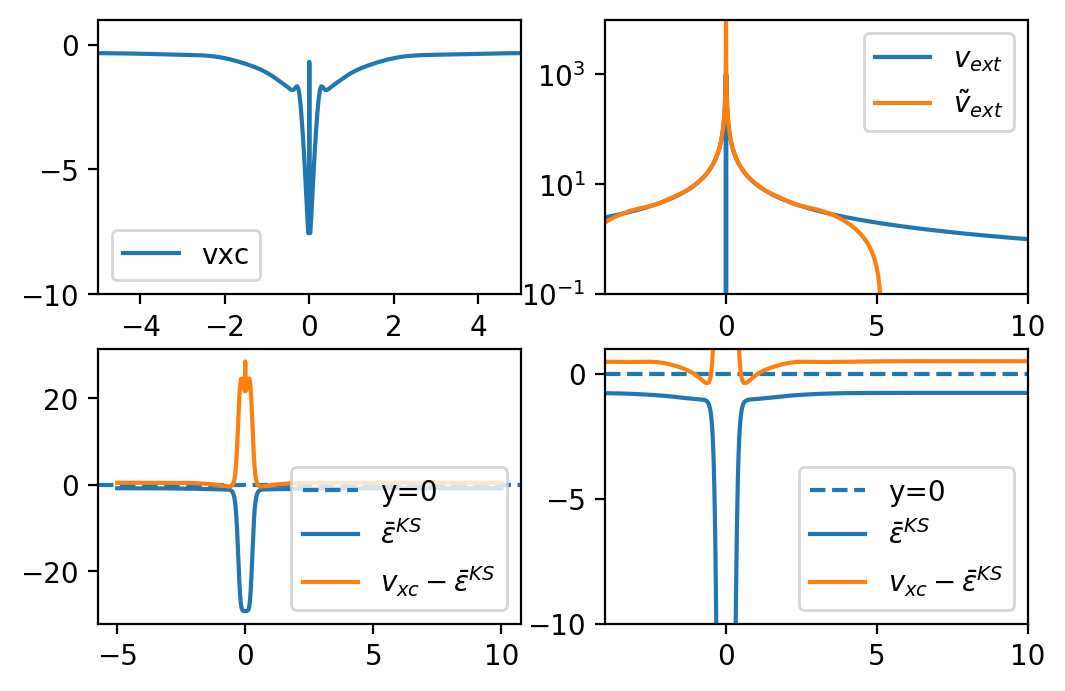

In [7]:
print(v[-1])
fig, ax = plt.subplots(2,2,dpi=200)
# ax[0,0].plot(Ne_xyz, Ne_vxc, label="QMC")
ax[0,0].plot(x, v[0], label='vxc')
ax[0,0].set_ylim(-10, 1)
ax[0,0].set_xlim(-5,5)
# ax[0,0].set_xscale('log')
ax[0,0].legend()
print(v[0][-1])


ax[0,1].plot(x, -vext, label="$v_{ext}$")
ax[0,1].plot(x, -vext_eff, label="$\\tilde{v}_{ext}$")
ax[0,1].set_xlim(-4, 10)
ax[0,1].set_ylim(1e-1, 1e4)
ax[0,1].set_yscale('log')
ax[0,1].legend()
print(v[1][-1])

ax[1,0].axhline(y=0, ls='--', label='y=0')
ax[1,0].plot(x, v[1], label='$\\bar{\epsilon}^{KS}$')
ax[1,0].plot(x, -v[2]-v[4]-v[3]-v[5], label="$v_{xc} - \\bar{\epsilon}^{KS}$")
ax[1,0].legend(loc='lower right')
print((-v[2] - v[4] - v[5])[-1])

ax[1,1].axhline(y=0, ls='--', label='y=0')
ax[1,1].plot(x, v[1], label='$\\bar{\epsilon}^{KS}$')
ax[1,1].plot(x, -v[2]-v[4]-v[3]-v[5], label="$v_{xc} - \\bar{\epsilon}^{KS}$")
ax[1,1].legend()
ax[1,1].set_xlim(-4, 10)
ax[1,1].set_ylim(-10, 1)

# fig.savefig("OuCarter_Ne.pdf")

(-4, 4)

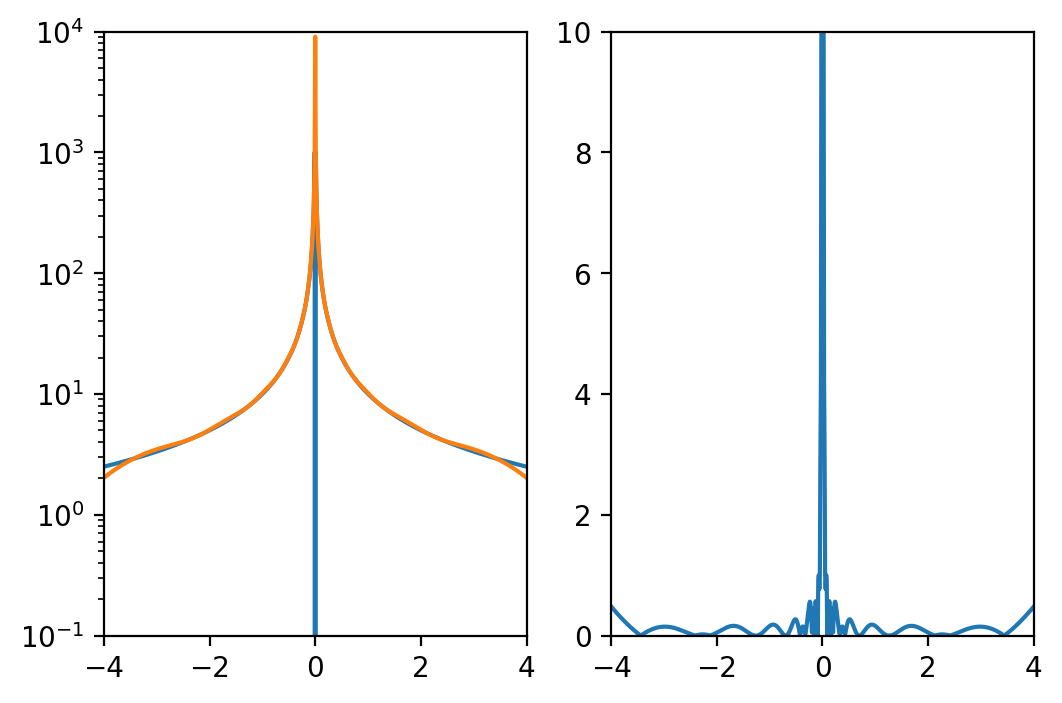

In [8]:
fig, ax = plt.subplots(1,2, dpi=200)
ax[0].plot(x, -vext)
ax[0].plot(x, -vext_eff)
ax[0].set_xlim(-4, 4)
ax[0].set_ylim(1e-1, 1e4)
ax[0].set_yscale('log')

ax[1].plot(x, np.abs(vext-vext_eff))
ax[1].set_ylim(0, 10)
ax[1].set_xlim(-4, 4)


Finally take a look at the LDA XC potential:

In [9]:
wfn_LDA = psi4.energy("SVWN/" + ine.basis_str, molecule=ine.mol, return_wfn=True)[1]
Da_LDA = wfn_LDA.Da().np
Db_LDA = wfn_LDA.Db().np

vxc_LDA = ine.on_grid_vxc(Da=Da_LDA, Db=Db_LDA, grid=grid_info)

(-10, 1)

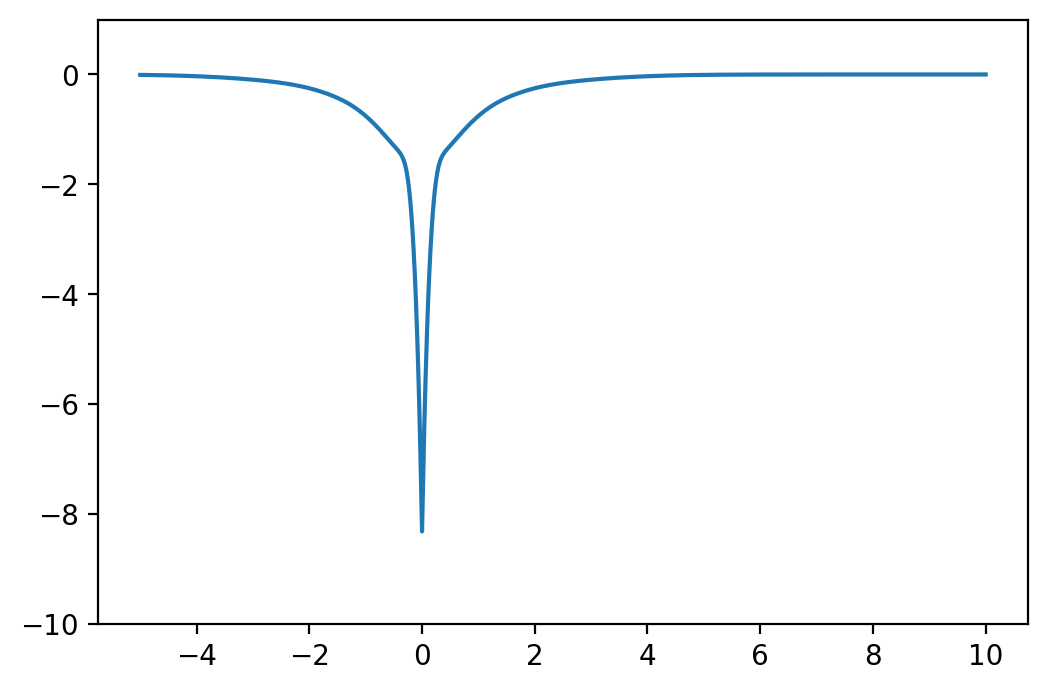

In [10]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x, vxc_LDA)

ax.set_ylim(-10, 1)

In [11]:
ine.eigvecs_a[:5]

array([-30.68241744,  -1.61000187,  -0.75866214,  -0.75866214,
        -0.75866214])

In [12]:
wfn.epsilon_a().np[:5]

array([-32.77150214,  -1.92933923,  -0.84898351,  -0.84898351,
        -0.84898351])